# Spatiotemporal gene expression trajectories with age (cell type-specific, subregion-specific)

This notebook contains code for defining and clustering gene expression trajectories into discrete trajectory clusters. The trajectory clusters are visualized by representative trajectories and individual genes can be visualized using spatiotemporal trajectory heatmaps showing the trajectory behavior for all cell types and subregions.

**Associated manuscript figures/tables:**
- Figures: 1h,i
- Extended Data Figures: 4d,e,f,g
- Supplementary Figure 1
- Supplementary Table 7 (partial)


**Inputs required:**
- `data/integrated_aging_coronal_celltyped_regioned_raw.h5ad` - AnnData object for coronal sections dataset
- `results/pathway_enrichment/go_oligo_cc_aco_BP.xlsx` - spreadsheet containing GO biological process enrichment results for the genes in the different trajectories for oligodendrocytes in the CC/ACO subregion (generated from `go_analysis.R` and also corresponds to Supplementary Table 9)
- `results/dgea/celltype_dgea_spearman_combinedbulked.csv` - dataframe with the increasing/decreasing gene classifications (generated from `2C_differential_gene_expression_analysis.ipynb`)

**Conda environment used**: `requirements/merfish.txt`

In [1]:
import scanpy as sc
import squidpy as sq
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
import seaborn as sns
import anndata as ad
import os
from scipy.stats import pearsonr, spearmanr, mannwhitneyu, ttest_ind, hypergeom
import matplotlib.colors as mcolors

import statsmodels.api as sm
from statsmodels.stats.multitest import multipletests
import pickle
import gseapy as gp

import umap
from sklearn.cluster import KMeans, DBSCAN
from sklearn.preprocessing import StandardScaler
from scipy.interpolate import make_interp_spline
from scipy.interpolate import splrep, BSpline
from scipy.signal import savgol_filter

/home/edsun/.conda/envs/merfish/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Compute mean vectors for celltype x region by age

In [2]:
adata = sc.read_h5ad("data/integrated_aging_coronal_celltyped_regioned_raw.h5ad")

In [ ]:
sc.pp.normalize_total(adata) # normalize for each cell

In [4]:
# Extract mean aging expression trajectories for gene-celltype-region combinations

missingness_threshold = 0.3

#--------------------------------------------
labels = []
age_expn_vectors = []

ages = np.unique(adata.obs.age)

for ct in np.unique(adata.obs.celltype): # loop cell types
    
    for region in np.unique(adata.obs.region): # loop regions
        sub_adata = adata[(adata.obs.celltype==ct)&(adata.obs.region==region)].copy()
        
        # check that enough ages are present in trajectory
        if len(np.unique(sub_adata.obs.age)) >= (1-missingness_threshold)*len(np.unique(adata.obs.age)):
            
            for gene in adata.var_names: # loop genes
                
                labels.append(f"{gene}_{ct}_{region}")
                age_expn_vector = []
                
                # generate trajectories across age
                for age in ages:
                    if age in np.unique(sub_adata.obs.age):
                        age_expn_vector.append(float(np.mean(sub_adata[sub_adata.obs.age==age,gene].X)))
                    else:
                        age_expn_vector.append(np.nan)
                
                # impute any missing values (LOCF)
                curr_value = 0
                for ei, expn in enumerate(age_expn_vector):
                    if np.isnan(expn):
                        age_expn_vector[ei] = curr_value
                    else:
                        curr_value = expn
                        
                # append trajectory
                age_expn_vectors.append(age_expn_vector)

In [5]:
# save results as dataframe

df = pd.DataFrame(np.vstack(age_expn_vectors).T, columns=labels)
df["age"] = ages
df.to_csv("results/gene_trajectory/gene_celltype_region_mean_age_expression_raw_LOCF03.csv", index=None)

## Perform clustering on age expression vectors

In [7]:
# load results
#df = pd.read_csv("results/gene_trajectory/gene_celltype_region_mean_age_expression_raw.csv")
df = pd.read_csv("results/gene_trajectory/gene_celltype_region_mean_age_expression_raw_LOCF03.csv")

In [8]:
# extract matrix
ages = df['age'].values.copy()
age_expn_matrix = df.values

# standardize so clustering done on trends
age_expn_matrix = StandardScaler().fit_transform(age_expn_matrix)
age_expn_matrix = age_expn_matrix.T

In [9]:
# clustering (K-means)
#kmeans = KMeans(n_clusters=9, random_state=444, n_init="auto").fit(age_expn_matrix)
#kmeans = KMeans(n_clusters=3, random_state=444, n_init="auto").fit(age_expn_matrix)
kmeans = KMeans(n_clusters=15, random_state=444, n_init="auto").fit(age_expn_matrix)

In [16]:
# np.savetxt("results/gene_trajectory/age_expn_matrixLOCF03.csv", age_expn_matrix)

# import pickle

# # save
# with open("results/gene_trajectory/kmeansLOCF03.pkl",'wb') as f:
#     pickle.dump(kmeans,f)

## Final Figures

In [5]:
# load clustering results
df = pd.read_csv("results/gene_trajectory/gene_celltype_region_mean_age_expression_raw_LOCF03.csv")
ages = df['age'].values.copy()
df = df.drop(columns='age')

age_expn_matrix = np.loadtxt("results/gene_trajectory/age_expn_matrixLOCF03.csv")

with open("results/gene_trajectory/kmeansLOCF03.pkl",'rb') as f:
    kmeans = pickle.load(f)

In [7]:
# Cluster annotations
colors = ['firebrick', 'lightcoral', 'tan',
          'goldenrod', 'grey', 'olive', 
          'darkkhaki', 'cornflowerblue', 'royalblue'] # olive, darkkhaki
# labels = [7,8,0,
#           5,3,4,
#           6,2,1]
labels = [6,0,3,
          4,8,5,
          2,7,1]

group_names = ["Increasing Late", "Increasing Gradual", "Midlife Trough",
               "Early Peak","Midlife Peak","Late Peak",
               "Midlife Decrease","Decreasing Early", "Decreasing Gradual"]

group_names_detailed = [f"{group_names[ii]}\n({np.sum(kmeans.labels_==labels[ii])})" for ii in range(len(group_names))]

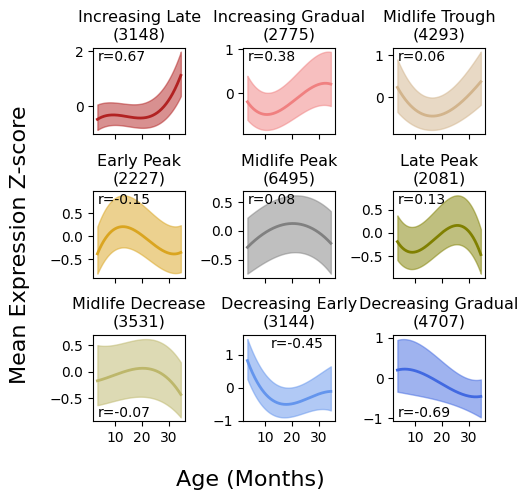

In [10]:
### make plot
nrows = 3
ncols = 3

# pos_dict = {"br": (0.3, 0.2, 0.05),
#             "bl": (0.05, 0.2, 0.05),
#             "tr": (0.3, 0.85, 0.7),
#             "tl": (0.05, 0.85, 0.7)}

pos_dict = {"br": (0.3, 0.05),
            "bl": (0.05, 0.05),
            "tr": (0.3, 0.85),
            "tl": (0.05, 0.85)}

corner_for_annot = ["tl", "tl", "tl",
                    "tl", "tl", "tl",
                    "bl", "tr", "bl"]

fig, axs = plt.subplots(nrows, ncols, figsize=(5,5), sharex=True, sharey=False)

counter = 0
for i in range(nrows):
    for j in range(ncols):
        
        lab = labels[counter]
        
        # subset into cluster
        sub_age_expn_matrix = age_expn_matrix[kmeans.labels_==lab,:]
        
        # compute mean and spread for each cluster
        median_expn = np.median(sub_age_expn_matrix,axis=0)
        spread_expn_upper = np.percentile(sub_age_expn_matrix,75,axis=0)
        spread_expn_lower = np.percentile(sub_age_expn_matrix,25,axis=0)
        
        # smoothen mean trajectories
        ages_fine = np.linspace(np.min(ages), np.max(ages), 500)
        
        smoother = BSpline(*splrep(ages, median_expn, s=len(ages)))
        median_expn_smooth = smoother(ages_fine)
        
        smoother = BSpline(*splrep(ages, spread_expn_upper, s=len(ages)))
        spread_expn_upper_smooth= smoother(ages_fine)
        
        smoother = BSpline(*splrep(ages, spread_expn_lower, s=len(ages)))
        spread_expn_lower_smooth= smoother(ages_fine)
        
        # plot mean and spread
        axs[i,j].plot(ages_fine, median_expn_smooth, color=colors[counter], linewidth=2)
        axs[i,j].fill_between(ages_fine, spread_expn_lower_smooth, spread_expn_upper_smooth, color=colors[counter], alpha=0.5)
        
        # annotate with stats
        r,p = pearsonr(ages, median_expn)
        #x, y1, y2 = pos_dict[corner_for_annot[j+i*ncols]]
        x, y1 = pos_dict[corner_for_annot[j+i*ncols]]
        axs[i,j].text(x, y1, "r="+str(round(r,2)), transform=axs[i,j].transAxes, 
            size=10)
        
        # set title
        axs[i,j].set_title(group_names_detailed[counter], fontsize=11.5)
        
        counter += 1

for a in axs.flatten():
    a.tick_params(axis='both', which='major', labelsize=10)
    a.tick_params(axis='both', which='minor', labelsize=10)
        
# make figure
fig.supxlabel("Age (Months)", fontsize=16)
fig.supylabel("Mean Expression Z-score", fontsize=16) # median of means is center line
plt.tight_layout()
plt.savefig("plots/gene_trajectory/paneled_mean_trajectories_k9_p5smoothed.pdf", bbox_inches='tight')
plt.show()

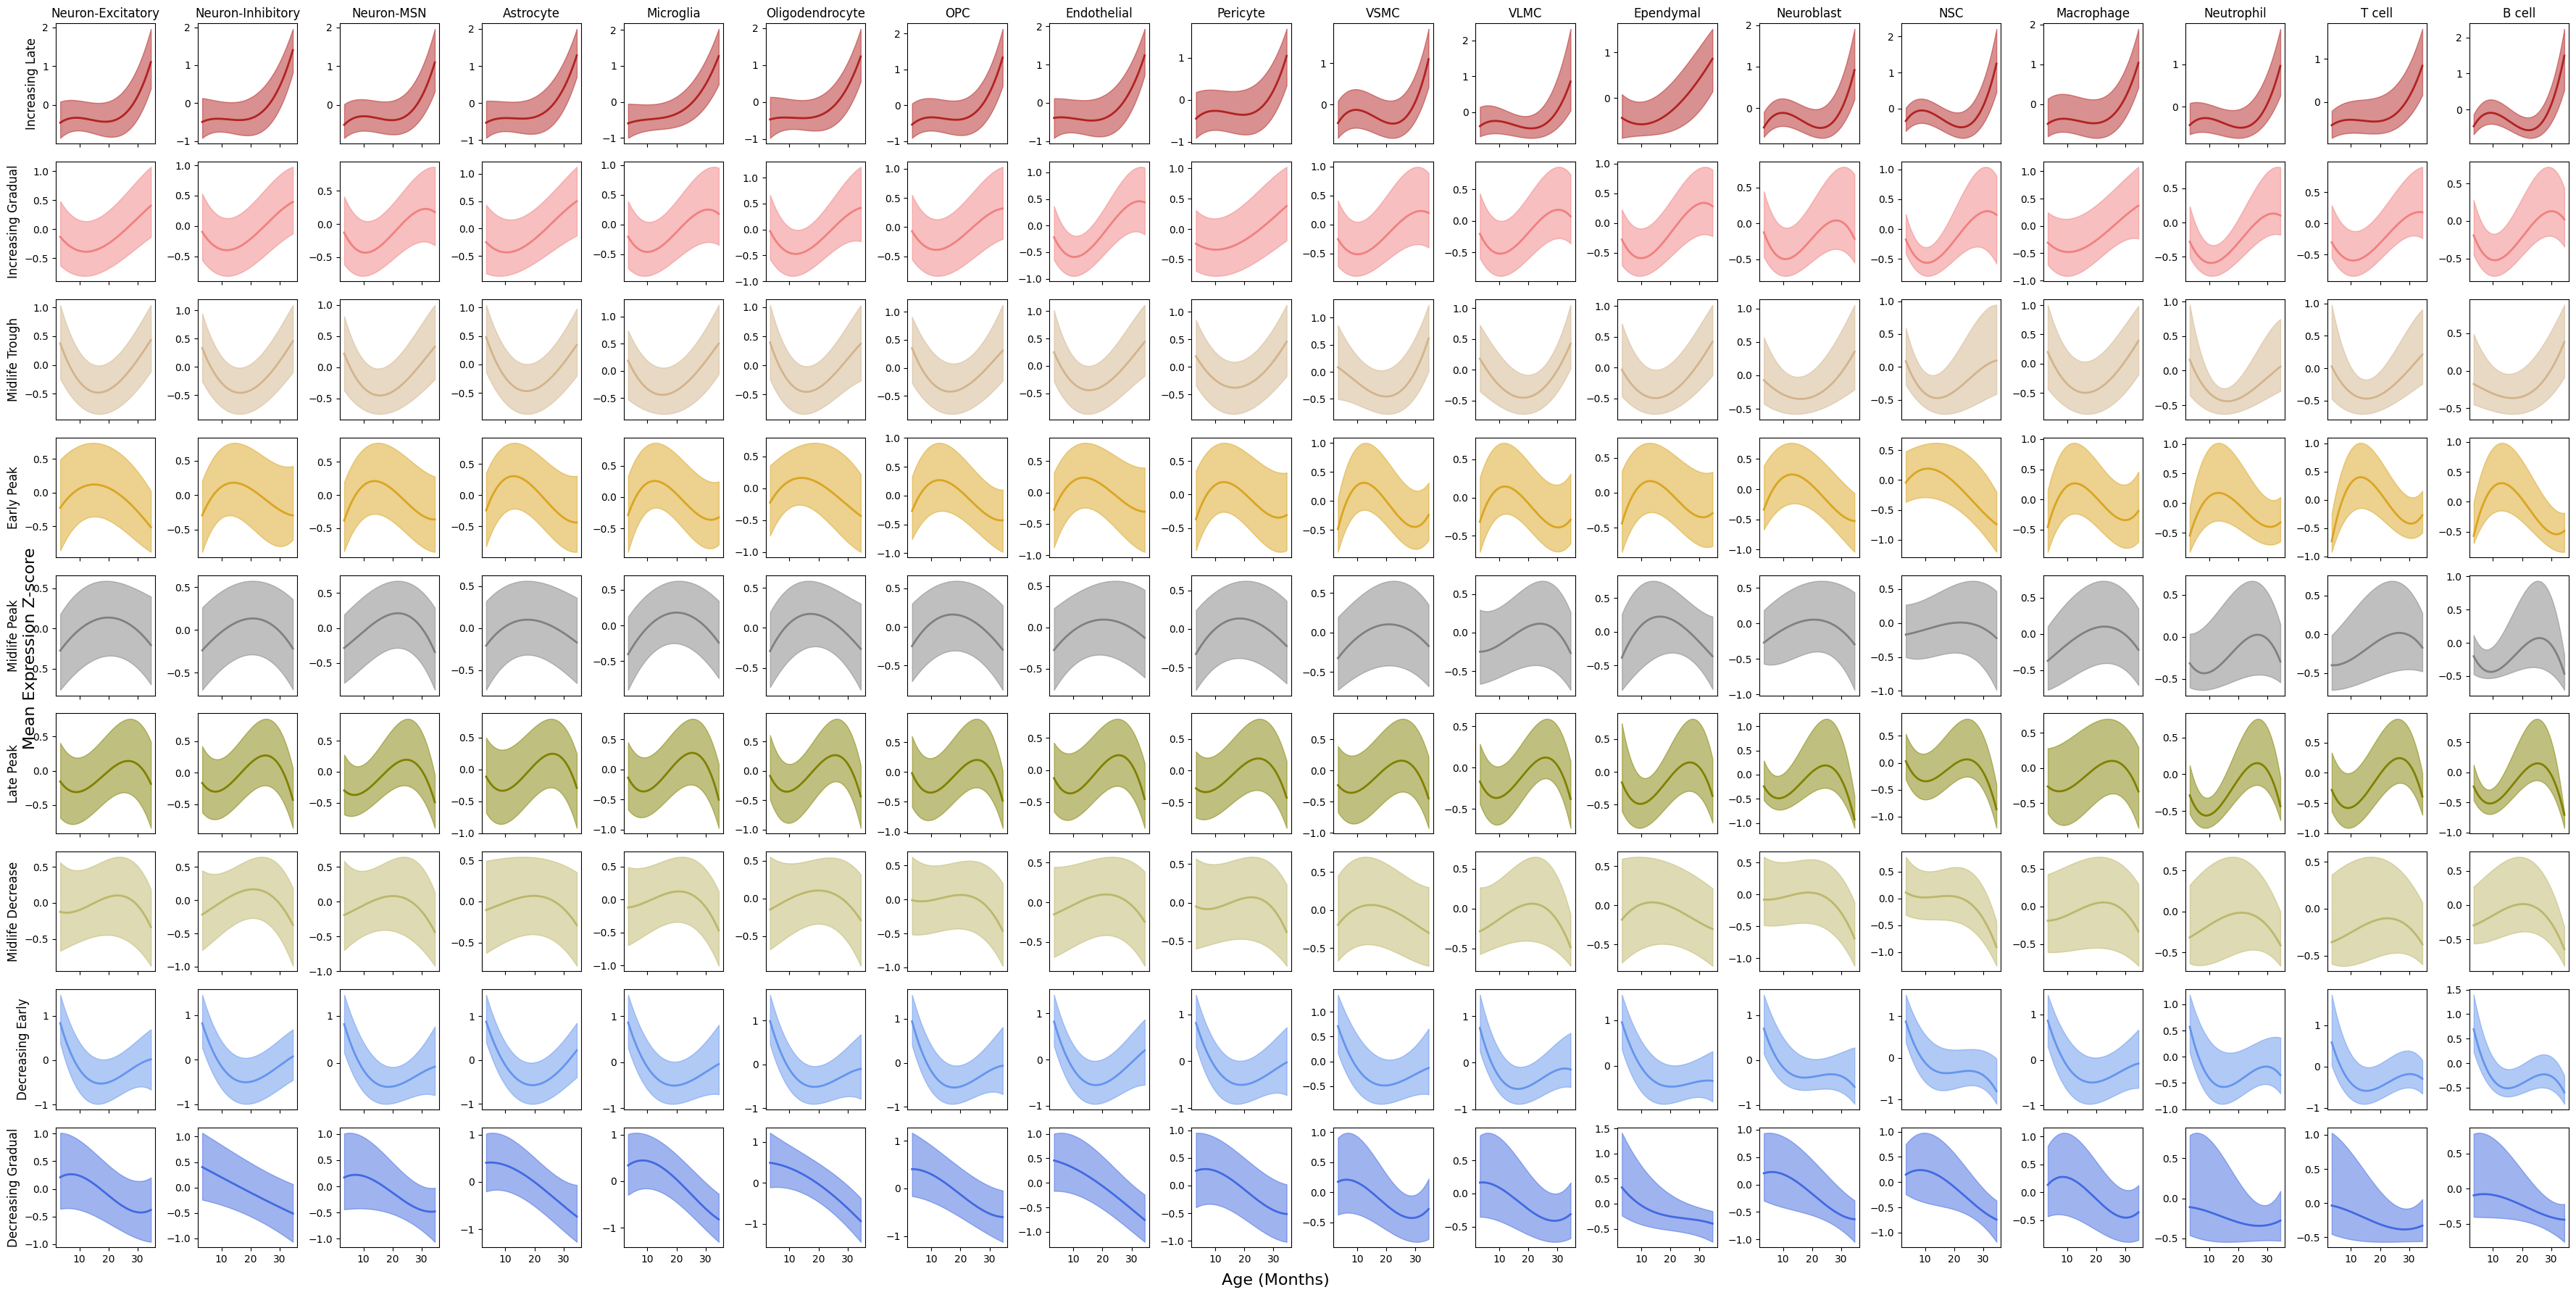

In [116]:
### make plot (By Celltype)

rows = []
cols = ['Neuron-Excitatory', 'Neuron-Inhibitory', 'Neuron-MSN',
        'Astrocyte', 'Microglia', 'Oligodendrocyte', 'OPC',
        'Endothelial', 'Pericyte', 'VSMC', 'VLMC',
        'Ependymal', 'Neuroblast', 'NSC', 
        'Macrophage', 'Neutrophil','T cell', 'B cell']

nrows = 9
ncols = 18


fig, axs = plt.subplots(nrows, ncols, figsize=(2*ncols,2*nrows), sharex=True, sharey=False)

celltypes = np.array([x.split("_")[1] for x in df.columns]+["NA"])

for i in range(nrows):
    
    rows.append(group_names[i])
    
    for j in range(ncols):
        
        lab = labels[i]
        
        ct = cols[j]
        
        # subset into cluster
        sub_age_expn_matrix = age_expn_matrix[(kmeans.labels_==lab)&(celltypes==ct),:]
        
        # compute mean and spread for each cluster
        median_expn = np.median(sub_age_expn_matrix,axis=0)
        spread_expn_upper = np.percentile(sub_age_expn_matrix,75,axis=0)
        spread_expn_lower = np.percentile(sub_age_expn_matrix,25,axis=0)
        
        # smoothen mean trajectories
        ages_fine = np.linspace(np.min(ages), np.max(ages), 500)
        
        smoother = BSpline(*splrep(ages, median_expn, s=len(ages)))
        median_expn_smooth = smoother(ages_fine)
        
        smoother = BSpline(*splrep(ages, spread_expn_upper, s=len(ages)))
        spread_expn_upper_smooth= smoother(ages_fine)
        
        smoother = BSpline(*splrep(ages, spread_expn_lower, s=len(ages)))
        spread_expn_lower_smooth= smoother(ages_fine)
        
        # plot mean and spread
        axs[i,j].plot(ages_fine, median_expn_smooth, color=colors[i], linewidth=2)
        axs[i,j].fill_between(ages_fine, spread_expn_lower_smooth, spread_expn_upper_smooth, color=colors[i], alpha=0.5)
        
        
for ax, col in zip(axs[0], cols):
    ax.set_title(col)

for ax, row in zip(axs[:,0], rows):
    ax.set_ylabel(row, rotation=90, size='large')
        
for a in axs.flatten():
    a.tick_params(axis='both', which='major', labelsize=10)
    a.tick_params(axis='both', which='minor', labelsize=10)
        
# make figure
fig.supxlabel("Age (Months)", fontsize=16)
fig.supylabel("Mean Expression Z-score", fontsize=16) # median of means is center line
fig.tight_layout()
plt.savefig("plots/gene_trajectory/paneled_mean_trajectories_k9_p5smoothed_byCelltype.pdf", bbox_inches='tight')
plt.show()

In [45]:
# save trajectory at gene level annotations

parsed_meta = [x.split("_") for x in df.columns]

traj_genes = np.array([p[0] for p in parsed_meta])
ctreg_trajs = {}
ctreg_trajs["gene"] = np.unique(adata.var_names)

# iterate and get annotations
for gene in ctreg_trajs["gene"]:
    
    search_idxs = np.where(traj_genes==gene)[0]
    
    for si in search_idxs:
        ctreg = "_".join(parsed_meta[si][1:])
        if ctreg not in ctreg_trajs.keys():
            ctreg_trajs[ctreg] = []
        ctreg_trajs[ctreg].append(group_names[labels.index(kmeans.labels_[si])])

In [46]:
traj_df = pd.DataFrame.from_dict(ctreg_trajs)
traj_df.to_csv("results/gene_trajectory/gene_trajectories_LOCF03.csv", index=False)

In [3]:
# Combine with DEG dataframe and save

traj_df = pd.read_csv("results/gene_trajectory/gene_trajectories_LOCF03.csv")
deg_df = pd.read_csv("results/dgea/celltype_dgea_spearman_combinedbulked.csv")

combined_df = pd.merge(deg_df, traj_df, on="gene")
combined_df.to_csv("results/gene_trajectory/combined_results_DEG_TRAJLOCF03.csv", index=False)

In [ ]:
# Make gene heatmap plots

gene_list = ["Stat1","Ifi27","Cat","Gamt",
             "Cdkn1a","H2-K1","Bst2","Fcrls","Casp2","Brca1"]
#------------------------------------------------------------------

regions_ordered = ['CTX_L1/MEN', 'CTX_L2/3', 'CTX_L4/5/6', 'STR_CP/ACB', 'STR_LS/NDB', 'CC/ACO', 'VEN']

for gene in gene_list:

    label_arr = np.empty((len(pd.unique(adata.obs.celltype).sort_values()),len(np.unique(adata.obs.region))))

    for ci, ct in enumerate(pd.unique(adata.obs.celltype).sort_values()):
        for ri, region in enumerate(regions_ordered):
            if f"{gene}_{ct}_{region}" in df.columns:
                col_idx = np.where(df.columns==f"{gene}_{ct}_{region}")[0][0]
                label_arr[ci,ri] = labels.index(kmeans.labels_[col_idx])
            else:
                label_arr[ci,ri] = np.nan


    # build array for heatmap
    color_arr = np.empty_like(label_arr, dtype="<U100")
    name_arr = np.empty_like(label_arr, dtype="<U100")

    for i in range(label_arr.shape[0]):
        for j in range(label_arr.shape[1]):
            if not np.isnan(label_arr[i,j]):
                color_arr[i,j] = colors[int(label_arr[i,j])]
                name_arr[i,j] = group_names[int(label_arr[i,j])]
            else:
                color_arr[i,j] = "w"
                name_arr[i,j] = ""

    # Create a colormap dictionary to map colors to numerical values
    colormap = {}
    for ci, col in enumerate(colors+["w"]):
        colormap[col] = ci

    # Convert color_arr to numerical values based on colormap
    numerical_color_arr = np.vectorize(colormap.get)(color_arr)

    # Create a custom colormap based on the colors in color_arr
    color_list = list(colormap.keys())
    custom_cmap = mcolors.ListedColormap(color_list)

    # Create the figure and axes
    fig, ax = plt.subplots(figsize=(7,5))

    # Create the heatmap plot
    heatmap = ax.imshow(numerical_color_arr, cmap=custom_cmap)

    # Set the tick labels and positions for x-axis
    ax.set_xticks(np.arange(len(name_arr[0])))
    ax.set_xticklabels(regions_ordered, rotation=90, fontsize=12)
    ax.set_xlabel('Subregion', fontsize=14)

    # Set the tick labels and positions for y-axis
    ax.set_yticks(np.arange(len(name_arr)))
    ax.set_yticklabels(pd.unique(adata.obs.celltype).sort_values(), fontsize=12)
    ax.set_ylabel('Cell Type', fontsize=14)

    # Create a legend for the color labels
    legend_labels = group_names+["Missing"]
    legend_elements = [plt.Line2D([0], [0], marker='s', color='w', markerfacecolor=color, label=label, markersize=10, markeredgewidth=0.25, markeredgecolor='k', linewidth=0)
                       for color, label in zip(color_list, legend_labels)]
    ax.legend(handles=legend_elements, loc='center left', bbox_to_anchor=(1, 0.5), fontsize=12)
    plt.title(f"{gene}", fontsize=16)

    plt.tight_layout()
    plt.savefig(f"plots/gene_trajectory/heatmap_trajclusters_{gene}.pdf", bbox_inches='tight')
    plt.show()

## GO enrichment for Oligo in CC/ACO (vignette)

In [2]:
# read in Excel results
df_dict = pd.read_excel("results/pathway_enrichment/go_oligo_cc_aco_BP.xlsx",
                   sheet_name=None)

In [3]:
# go through sheets and collect into one dataframe

top_n = 3

top_df_list = []
df_list = []

for sheet in df_dict.keys():
    sdf = df_dict[sheet]
    sdf["trajectory"] = sheet
    sdf["neglog10Fisher"] = -np.log10(sdf["Fisher"])
    sdf = sdf.sort_values(by="Fisher")
    top_df_list.append(sdf.head(top_n))
    df_list.append(sdf)

top_df = pd.concat(top_df_list)
df = pd.concat(df_list)

# reorder cell types
group_names = ["Increasing Late", "Increasing Gradual", "Midlife Trough",
               "Early Peak","Midlife Peak","Late Peak",
               "Midlife Decrease","Decreasing Early", "Decreasing Gradual"]

top_df["trajectory"] = top_df["trajectory"].astype('category').cat.reorder_categories(group_names)
top_df = top_df.sort_values(by=["trajectory","Fisher"])

df["trajectory"] = df["trajectory"].astype('category').cat.reorder_categories(group_names)
df = df.sort_values(by=["trajectory","Fisher"])

In [ ]:
sub_top_df = top_df
sub_df = df

#-----------------------------------------

# subset only top terms
top_terms = sub_top_df["Term"].values
sub_df = sub_df[sub_df["Term"].isin(top_terms)]
sub_df["Term"] = sub_df["Term"].astype('category').cat.reorder_categories(pd.unique(top_terms))


pivot_df = sub_df.pivot("Term", "trajectory", "neglog10Fisher")


# PLOT

fig, ax = plt.subplots(figsize=(6,12))

# make colored heatmap
sns.heatmap(pivot_df, ax=ax, square=False, cmap="Greys", vmin=0)

ax.collections[0].colorbar.set_label('Negative Log10 P-value',
                                    rotation=270, fontsize=18, labelpad=23)
ax.collections[0].colorbar.ax.tick_params(labelsize=14)

plt.title("Oligodendrocyte in CC/ACO", fontsize=20)
plt.ylabel("GO Biological Process", fontsize=18)
plt.xlabel("Trajectory Classification", fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.tight_layout()
plt.savefig("plots/pathways/trajectory_oligo_ccaco.pdf",
          bbox_inches='tight')
plt.show()

## Other choices of k=3, k=15

### k=3

In [11]:
# load clustering results
df = pd.read_csv("results/gene_trajectory/gene_celltype_region_mean_age_expression_raw_LOCF03.csv")
ages = df['age'].values.copy()
df = df.drop(columns='age')

age_expn_matrix = np.loadtxt("results/gene_trajectory/age_expn_matrixLOCF03.csv")

with open("results/gene_trajectory/kmeansLOCF03_k3.pkl",'rb') as f:
    kmeans = pickle.load(f)

In [13]:
colors = ['lightcoral', 'grey', 'cornflowerblue']

labels = [0,1,2]

group_names = ["Increasing", "Unchanged", "Decreasing"]

group_names_detailed = [f"{group_names[ii]}\n({np.sum(kmeans.labels_==labels[ii])})" for ii in range(len(group_names))]

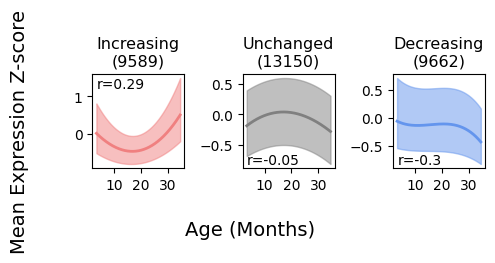

In [14]:
### make plot
nrows = 1
ncols = 3

pos_dict = {"br": (0.3, 0.05),
            "bl": (0.05, 0.05),
            "tr": (0.3, 0.85),
            "tl": (0.05, 0.85)}

corner_for_annot = ["tl", "bl", "bl"]

fig, axs = plt.subplots(nrows, ncols, figsize=(5,2.2), sharex=True, sharey=False)

counter = 0
for i in range(nrows):
    for j in range(ncols):
        
        lab = labels[counter]
        
        # subset into cluster
        sub_age_expn_matrix = age_expn_matrix[kmeans.labels_==lab,:]
        
        # compute mean and spread for each cluster
        median_expn = np.median(sub_age_expn_matrix,axis=0)
        spread_expn_upper = np.percentile(sub_age_expn_matrix,75,axis=0)
        spread_expn_lower = np.percentile(sub_age_expn_matrix,25,axis=0)
        
        # smoothen mean trajectories
        ages_fine = np.linspace(np.min(ages), np.max(ages), 500)
        
        smoother = BSpline(*splrep(ages, median_expn, s=len(ages)))
        median_expn_smooth = smoother(ages_fine)
        
        smoother = BSpline(*splrep(ages, spread_expn_upper, s=len(ages)))
        spread_expn_upper_smooth= smoother(ages_fine)
        
        smoother = BSpline(*splrep(ages, spread_expn_lower, s=len(ages)))
        spread_expn_lower_smooth= smoother(ages_fine)
        
        # plot mean and spread
        axs[j].plot(ages_fine, median_expn_smooth, color=colors[counter], linewidth=2)
        axs[j].fill_between(ages_fine, spread_expn_lower_smooth, spread_expn_upper_smooth, color=colors[counter], alpha=0.5)
        
        # annotate with stats
        r,p = pearsonr(ages, median_expn)
        x, y1 = pos_dict[corner_for_annot[j+i*ncols]]
        axs[j].text(x, y1, "r="+str(round(r,2)), transform=axs[j].transAxes, 
            size=10)
        
        # set title
        axs[j].set_title(group_names_detailed[counter], fontsize=11.5)
        
        counter += 1

for a in axs.flatten():
    a.tick_params(axis='both', which='major', labelsize=10)
    a.tick_params(axis='both', which='minor', labelsize=10)
        
# make figure
fig.supxlabel("Age (Months)", fontsize=14)
fig.supylabel("Mean Expression Z-score", fontsize=14) # median of means is center line
plt.tight_layout()
plt.savefig("plots/gene_trajectory/paneled_mean_trajectories_k3_p5smoothed.pdf", bbox_inches='tight')
plt.show()

### k=15

In [15]:
# load clustering results
df = pd.read_csv("results/gene_trajectory/gene_celltype_region_mean_age_expression_raw_LOCF03.csv")
ages = df['age'].values.copy()
df = df.drop(columns='age')

age_expn_matrix = np.loadtxt("results/gene_trajectory/age_expn_matrixLOCF03.csv")

with open("results/gene_trajectory/kmeansLOCF03_k15.pkl",'rb') as f:
    kmeans = pickle.load(f)

In [17]:
# Cluster annotations
colors = ['firebrick', 'lightcoral', 'tan',
          'goldenrod', 'grey', 'olive', 
          'darkkhaki', 'cornflowerblue', 'royalblue',
          'pink', 'green', 'tab:orange', 'm', 'c', 'y']

labels = [0,1,2,3,4,
          5,6,7,8,9,
          10,11,12,13,14]

group_names = [f"Cluster {i+1}" for i in range(15)]

group_names_detailed = [f"{group_names[ii]}\n({np.sum(kmeans.labels_==labels[ii])})" for ii in range(len(group_names))]

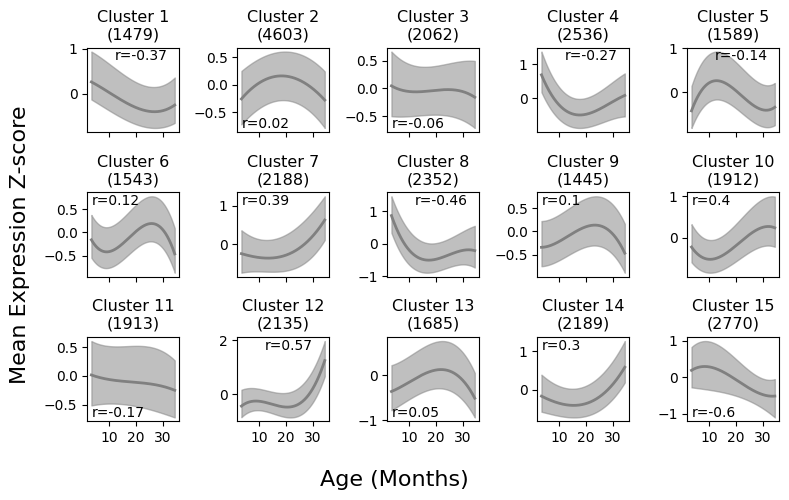

In [19]:
### make plot
nrows = 3
ncols = 5

pos_dict = {"br": (0.3, 0.05),
            "bl": (0.05, 0.05),
            "tr": (0.3, 0.85),
            "tl": (0.05, 0.85)}

corner_for_annot = ["tr", "bl", "bl", "tr", "tr",
                    "tl", "tl", "tr", "tl", "tl",
                    "bl", "tr", "bl", "tl", "bl",]

fig, axs = plt.subplots(nrows, ncols, figsize=(8,5), sharex=True, sharey=False)

counter = 0
for i in range(nrows):
    for j in range(ncols):
        
        lab = labels[counter]
        
        # subset into cluster
        sub_age_expn_matrix = age_expn_matrix[kmeans.labels_==lab,:]
        
        # compute mean and spread for each cluster
        median_expn = np.median(sub_age_expn_matrix,axis=0)
        spread_expn_upper = np.percentile(sub_age_expn_matrix,75,axis=0)
        spread_expn_lower = np.percentile(sub_age_expn_matrix,25,axis=0)
        
        # smoothen mean trajectories
        ages_fine = np.linspace(np.min(ages), np.max(ages), 500)
        
        smoother = BSpline(*splrep(ages, median_expn, s=len(ages)))
        median_expn_smooth = smoother(ages_fine)
        
        smoother = BSpline(*splrep(ages, spread_expn_upper, s=len(ages)))
        spread_expn_upper_smooth= smoother(ages_fine)
        
        smoother = BSpline(*splrep(ages, spread_expn_lower, s=len(ages)))
        spread_expn_lower_smooth= smoother(ages_fine)
        
        # plot mean and spread
        axs[i,j].plot(ages_fine, median_expn_smooth, color='grey', linewidth=2)
        axs[i,j].fill_between(ages_fine, spread_expn_lower_smooth, spread_expn_upper_smooth, color='grey', alpha=0.5)
        
        # annotate with stats
        r,p = pearsonr(ages, median_expn)
        x, y1 = pos_dict[corner_for_annot[j+i*ncols]]
        axs[i,j].text(x, y1, "r="+str(round(r,2)), transform=axs[i,j].transAxes, 
            size=10)
        
        # set title
        axs[i,j].set_title(group_names_detailed[counter], fontsize=11.5)
        
        counter += 1

for a in axs.flatten():
    a.tick_params(axis='both', which='major', labelsize=10)
    a.tick_params(axis='both', which='minor', labelsize=10)
        
# make figure
fig.supxlabel("Age (Months)", fontsize=16)
fig.supylabel("Mean Expression Z-score", fontsize=16) # median of means is center line
plt.tight_layout()
plt.savefig("plots/gene_trajectory/paneled_mean_trajectories_k15_p5smoothed.pdf", bbox_inches='tight')
plt.show()